In [1]:
# Install necessary libraries (if not already installed)
%pip install transformers datasets peft evaluate scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install ipywidgets
%pip install jupyterlab_widgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim import AdamW

In [4]:
# Paths
DATASET_PATH = '/Users/rumenguin/Research/MERC/EmoReact/dataset.csv'
TRAIN_NAMES_PATH = '/Users/rumenguin/Research/MERC/EmoReact/Labels/Train_names.txt'
VAL_NAMES_PATH = '/Users/rumenguin/Research/MERC/EmoReact/Labels/Val_names.txt'
TEST_NAMES_PATH = '/Users/rumenguin/Research/MERC/EmoReact/Labels/Test_names.txt'
MODEL_NAME = 'distilbert-base-uncased'  # Good balance of performance and efficiency for Mac M1
SAVE_DIR = '/Users/rumenguin/Research/MERC/models/saved_model'

# Create save directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [ ]:
# Load and preprocess the dataset
def load_video_names(file_path):
    with open(file_path, 'r') as f:
        # Remove quotes if present and strip whitespace
        return [line.strip().replace("'", "").replace('"', '') for line in f.readlines()]

# Load video names for train, val, and test sets
train_videos = load_video_names(TRAIN_NAMES_PATH)
val_videos = load_video_names(VAL_NAMES_PATH)
test_videos = load_video_names(TEST_NAMES_PATH)

print(f"Train videos: {len(train_videos)}")
print(f"Val videos: {len(val_videos)}")
print(f"Test videos: {len(test_videos)}")

# Load the dataset
df = pd.read_csv(DATASET_PATH)
print(f"Dataset shape: {df.shape}")

# Display first few rows to understand the data
df.head()

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Train videos: 432
Val videos: 303
Test videos: 367
Dataset shape: (1102, 6)
Missing values in each column:
ID              0
Video           0
Transcript     10
Behavior        0
Labels        138
Valence         0
dtype: int64


In [6]:
# Process Labels (emotions)
# Convert string representation of emotion labels to lists
def process_labels(labels):
    if pd.isna(labels) or labels == 'None' or labels == '':
        return []
    try:
        # Try to evaluate as a literal Python expression (list, tuple, etc.)
        return eval(labels)
    except:
        # If it's a simple string without brackets
        if isinstance(labels, str):
            return [label.strip() for label in labels.split(',')]
        return []

# Apply to the Labels column
df['Processed_Labels'] = df['Labels'].apply(process_labels)

# List all possible emotions
all_emotions = ['Curiosity', 'Uncertainty', 'Excitement', 'Happiness', 'Surprise', 'Disgust', 'Fear', 'Frustration']
print(f"All possible emotions: {all_emotions}")

All possible emotions: ['Curiosity', 'Uncertainty', 'Excitement', 'Happiness', 'Surprise', 'Disgust', 'Fear', 'Frustration']


In [7]:
# Convert Valence to numeric and handle missing values
df['Valence'] = pd.to_numeric(df['Valence'], errors='coerce')
# Fill missing valence with mean value
mean_valence = df['Valence'].mean()
df['Valence'] = df['Valence'].fillna(mean_valence)
print(f"Valence range: {df['Valence'].min()} to {df['Valence'].max()}")

# Create new column combining Transcript and Behavior
df['Combined_Text'] = df['Transcript'].fillna('') + ' ' + df['Behavior'].fillna('')
df['Combined_Text'] = df['Combined_Text'].str.strip()

# Handle cases where both transcript and behavior might be empty
df.loc[df['Combined_Text'] == '', 'Combined_Text'] = "No information available"


Valence range: 1.0 to 7.0


In [8]:
# Split dataset into train, val, test based on the video files
def get_video_name(video_path):
    return os.path.basename(video_path)

df['VideoName'] = df['Video'].apply(get_video_name)

train_df = df[df['VideoName'].isin(train_videos)]
val_df = df[df['VideoName'].isin(val_videos)]
test_df = df[df['VideoName'].isin(test_videos)]

print(f"Train set: {len(train_df)} samples")
print(f"Val set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Train set: 432 samples
Val set: 303 samples
Test set: 367 samples


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=all_emotions)
mlb.fit([all_emotions])  # Ensure all classes are represented

# One-hot encode the labels
train_labels_encoded = mlb.transform(train_df['Processed_Labels'].tolist())
val_labels_encoded = mlb.transform(val_df['Processed_Labels'].tolist())
test_labels_encoded = mlb.transform(test_df['Processed_Labels'].tolist())

# Save the class mapping
with open(os.path.join(SAVE_DIR, 'emotion_labels.json'), 'w') as f:
    json.dump({idx: emotion for idx, emotion in enumerate(mlb.classes_)}, f)

In [10]:
# Create a custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, texts, emotion_labels, valence_values, tokenizer, max_length=512):
        self.texts = texts
        self.emotion_labels = emotion_labels
        self.valence_values = valence_values
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        emotion_label = self.emotion_labels[idx]
        valence = self.valence_values[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Squeeze to remove batch dimension
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'emotion_labels': torch.FloatTensor(emotion_label),
            'valence': torch.FloatTensor([valence])
        }

In [11]:
from transformers import DistilBertModel
# Define the model
class EmotionValenceModel(nn.Module):
    def __init__(self, n_emotions, dropout_prob=0.3):
        super(EmotionValenceModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Freeze some layers of DistilBERT to reduce computational load and prevent overfitting
        modules = [self.distilbert.embeddings, *self.distilbert.transformer.layer[:2]]
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False
        
        hidden_size = self.distilbert.config.hidden_size
        
        # Common layers
        self.dropout = nn.Dropout(dropout_prob)
        self.pre_classifier = nn.Linear(hidden_size, 256)
        self.activation = nn.ReLU()
        
        # Emotion classification head
        self.emotion_classifier = nn.Linear(256, n_emotions)
        
        # Valence regression head
        self.valence_regressor = nn.Linear(256, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # Use [CLS] token representation
        
        x = self.dropout(hidden_state)
        x = self.pre_classifier(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Multi-label emotion classification (using sigmoid for multi-label)
        emotion_output = self.emotion_classifier(x)
        
        # Valence regression (value between 1-7)
        valence_output = self.valence_regressor(x)
        
        return emotion_output, valence_output


In [12]:
from transformers import DistilBertTokenizer
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
train_dataset = EmotionDataset(
    train_df['Combined_Text'].tolist(),
    train_labels_encoded,
    train_df['Valence'].tolist(),
    tokenizer
)

val_dataset = EmotionDataset(
    val_df['Combined_Text'].tolist(),
    val_labels_encoded,
    val_df['Valence'].tolist(),
    tokenizer
)

test_dataset = EmotionDataset(
    test_df['Combined_Text'].tolist(),
    test_labels_encoded,
    test_df['Valence'].tolist(),
    tokenizer
)

In [13]:
# Create data loaders
batch_size = 16  # Smaller batch size for M1 Mac

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
n_emotions = len(all_emotions)
model = EmotionValenceModel(n_emotions)
model = model.to(device)

# Define loss functions
emotion_criterion = nn.BCEWithLogitsLoss()
valence_criterion = nn.MSELoss()

# Define optimizer with weight decay for regularization
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Learning rate scheduler
num_epochs = 50
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [14]:
# Training loop

def train_model(model, train_loader, val_loader, optimizer, scheduler, emotion_criterion, valence_criterion, num_epochs, device):
    # For tracking metrics
    history = {
        'train_emotion_loss': [],
        'train_valence_loss': [],
        'train_total_loss': [],
        'val_emotion_loss': [],
        'val_valence_loss': [],
        'val_total_loss': [],
        'val_micro_f1': [],
        'val_macro_f1': [],
        'val_valence_rmse': [],
        'val_accuracy': []  # Added accuracy tracking
    }
    
    # Alpha parameter for balancing losses (can be adjusted)
    alpha = 0.7  # Weight for emotion loss
    beta = 0.3   # Weight for valence loss
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_emotion_loss = 0
        train_valence_loss = 0
        train_total_loss = 0
        
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        
        for batch_idx, batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            valence = batch['valence'].to(device)
            
            # Forward pass
            emotion_logits, valence_pred = model(input_ids, attention_mask)
            
            # Calculate losses
            e_loss = emotion_criterion(emotion_logits, emotion_labels)
            v_loss = valence_criterion(valence_pred, valence)
            
            # Weighted combined loss
            loss = alpha * e_loss + beta * v_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # Update metrics
            train_emotion_loss += e_loss.item()
            train_valence_loss += v_loss.item()
            train_total_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_description(f"Training - Loss: {loss.item():.4f}")
        
        # Calculate average training losses
        avg_train_emotion_loss = train_emotion_loss / len(train_loader)
        avg_train_valence_loss = train_valence_loss / len(train_loader)
        avg_train_total_loss = train_total_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_emotion_loss = 0
        val_valence_loss = 0
        val_total_loss = 0
        
        all_emotion_preds = []
        all_emotion_labels = []
        all_valence_preds = []
        all_valence_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                emotion_labels = batch['emotion_labels'].to(device)
                valence = batch['valence'].to(device)
                
                emotion_logits, valence_pred = model(input_ids, attention_mask)
                
                e_loss = emotion_criterion(emotion_logits, emotion_labels)
                v_loss = valence_criterion(valence_pred, valence)
                loss = alpha * e_loss + beta * v_loss
                
                val_emotion_loss += e_loss.item()
                val_valence_loss += v_loss.item()
                val_total_loss += loss.item()
                
                # Convert logits to predictions
                emotion_preds = torch.sigmoid(emotion_logits).cpu().numpy() > 0.5  # Threshold for multi-label classification
                # Convert lists to numpy arrays for F1 calculation
                
                all_emotion_preds.extend(emotion_preds.astype(int).tolist())
                all_emotion_labels.extend(emotion_labels.cpu().numpy().astype(int).tolist())
                all_valence_preds.extend(valence_pred.cpu().numpy().flatten().tolist())
                all_valence_labels.extend(valence.cpu().numpy().flatten().tolist())
        
        # Calculate validation metrics
        avg_val_emotion_loss = val_emotion_loss / len(val_loader)
        avg_val_valence_loss = val_valence_loss / len(val_loader)
        avg_val_total_loss = val_total_loss / len(val_loader)
        
        # F1 scores for emotion classification
        #micro_f1 = f1_score(all_emotion_labels, all_emotion_preds, average='micro')
        # macro_f1 = f1_score(all_emotion_labels, all_emotion_preds, average='macro')
        # Convert to numpy arrays
        emotion_preds_np = np.array(all_emotion_preds)
        emotion_labels_np = np.array(all_emotion_labels)

        # F1 scores for multi-label emotion classification
        micro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='micro', zero_division=0)
        macro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='macro', zero_division=0)
        
        # RMSE for valence prediction
        valence_rmse = np.sqrt(mean_squared_error(all_valence_labels, all_valence_preds))
        
        # Calculate accuracy for multi-label classification
        accuracy = np.mean(np.array(emotion_preds_np == emotion_labels_np, dtype=float))
        
        # Update history
        history['train_emotion_loss'].append(avg_train_emotion_loss)
        history['train_valence_loss'].append(avg_train_valence_loss)
        history['train_total_loss'].append(avg_train_total_loss)
        history['val_emotion_loss'].append(avg_val_emotion_loss)
        history['val_valence_loss'].append(avg_val_valence_loss)
        history['val_total_loss'].append(avg_val_total_loss)
        history['val_micro_f1'].append(micro_f1)
        history['val_macro_f1'].append(macro_f1)
        history['val_valence_rmse'].append(valence_rmse)
        history['val_accuracy'].append(accuracy)  # Added accuracy to history
        
        # Print metrics
        print(f"Train - Emotion Loss: {avg_train_emotion_loss:.4f}, Valence Loss: {avg_train_valence_loss:.4f}, Total Loss: {avg_train_total_loss:.4f}")
        print(f"Val - Emotion Loss: {avg_val_emotion_loss:.4f}, Valence Loss: {avg_val_valence_loss:.4f}, Total Loss: {avg_val_total_loss:.4f}")
        print(f"Val - Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}, Valence RMSE: {valence_rmse:.4f}, Accuracy: {accuracy:.4f}")  # Added accuracy to print statement
        
        # Save best model
        if avg_val_total_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'dbert_best_model.pt'))
            print("Saved best model!")
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'dbert_final_model.pt'))
    
    # Save training history
    with open(os.path.join(SAVE_DIR, 'dbert_training_history.json'), 'w') as f:
        json.dump(history, f)
    
    return history


In [15]:
# Train the model
history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    emotion_criterion,
    valence_criterion,
    num_epochs,
    device
)


Epoch 1/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.6760, Valence Loss: 9.8556, Total Loss: 3.4299
Val - Emotion Loss: 0.6540, Valence Loss: 2.6551, Total Loss: 1.2544
Val - Micro F1: 0.2348, Macro F1: 0.1263, Valence RMSE: 1.6298, Accuracy: 0.6774
Saved best model!

Epoch 2/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.6414, Valence Loss: 2.3491, Total Loss: 1.1537
Val - Emotion Loss: 0.6042, Valence Loss: 1.5159, Total Loss: 0.8777
Val - Micro F1: 0.0000, Macro F1: 0.0000, Valence RMSE: 1.2324, Accuracy: 0.7409
Saved best model!

Epoch 3/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5925, Valence Loss: 1.7962, Total Loss: 0.9536
Val - Emotion Loss: 0.5661, Valence Loss: 0.7039, Total Loss: 0.6074
Val - Micro F1: 0.0000, Macro F1: 0.0000, Valence RMSE: 0.8399, Accuracy: 0.7409
Saved best model!

Epoch 4/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5697, Valence Loss: 0.6875, Total Loss: 0.6051
Val - Emotion Loss: 0.5450, Valence Loss: 0.2426, Total Loss: 0.4543
Val - Micro F1: 0.3552, Macro F1: 0.1657, Valence RMSE: 0.4928, Accuracy: 0.7888
Saved best model!

Epoch 5/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5436, Valence Loss: 0.4155, Total Loss: 0.5052
Val - Emotion Loss: 0.5135, Valence Loss: 0.2353, Total Loss: 0.4300
Val - Micro F1: 0.4365, Macro F1: 0.1830, Valence RMSE: 0.4851, Accuracy: 0.8115
Saved best model!

Epoch 6/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.5181, Valence Loss: 0.3385, Total Loss: 0.4642
Val - Emotion Loss: 0.4902, Valence Loss: 0.2044, Total Loss: 0.4045
Val - Micro F1: 0.4919, Macro F1: 0.2024, Valence RMSE: 0.4522, Accuracy: 0.8185
Saved best model!

Epoch 7/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4968, Valence Loss: 0.3408, Total Loss: 0.4500
Val - Emotion Loss: 0.4736, Valence Loss: 0.1658, Total Loss: 0.3813
Val - Micro F1: 0.4180, Macro F1: 0.1713, Valence RMSE: 0.4072, Accuracy: 0.8082
Saved best model!

Epoch 8/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4807, Valence Loss: 0.2674, Total Loss: 0.4167
Val - Emotion Loss: 0.4620, Valence Loss: 0.2278, Total Loss: 0.3917
Val - Micro F1: 0.4904, Macro F1: 0.1999, Valence RMSE: 0.4770, Accuracy: 0.8148

Epoch 9/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4687, Valence Loss: 0.2885, Total Loss: 0.4146
Val - Emotion Loss: 0.4487, Valence Loss: 0.1472, Total Loss: 0.3583
Val - Micro F1: 0.4944, Macro F1: 0.2003, Valence RMSE: 0.3835, Accuracy: 0.8144
Saved best model!

Epoch 10/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4592, Valence Loss: 0.2580, Total Loss: 0.3988
Val - Emotion Loss: 0.4409, Valence Loss: 0.0884, Total Loss: 0.3351
Val - Micro F1: 0.4818, Macro F1: 0.2029, Valence RMSE: 0.2972, Accuracy: 0.8181
Saved best model!

Epoch 11/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4461, Valence Loss: 0.2477, Total Loss: 0.3866
Val - Emotion Loss: 0.4271, Valence Loss: 0.1421, Total Loss: 0.3416
Val - Micro F1: 0.4889, Macro F1: 0.1955, Valence RMSE: 0.3769, Accuracy: 0.8102

Epoch 12/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4394, Valence Loss: 0.2353, Total Loss: 0.3782
Val - Emotion Loss: 0.4171, Valence Loss: 0.1067, Total Loss: 0.3240
Val - Micro F1: 0.4902, Macro F1: 0.2029, Valence RMSE: 0.3266, Accuracy: 0.8172
Saved best model!

Epoch 13/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4299, Valence Loss: 0.2488, Total Loss: 0.3755
Val - Emotion Loss: 0.4098, Valence Loss: 0.1826, Total Loss: 0.3416
Val - Micro F1: 0.4983, Macro F1: 0.2008, Valence RMSE: 0.4270, Accuracy: 0.8131

Epoch 14/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4204, Valence Loss: 0.2832, Total Loss: 0.3792
Val - Emotion Loss: 0.3985, Valence Loss: 0.1104, Total Loss: 0.3120
Val - Micro F1: 0.5216, Macro F1: 0.2295, Valence RMSE: 0.3322, Accuracy: 0.8222
Saved best model!

Epoch 15/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.4050, Valence Loss: 0.2366, Total Loss: 0.3545
Val - Emotion Loss: 0.3827, Valence Loss: 0.1084, Total Loss: 0.3004
Val - Micro F1: 0.6215, Macro F1: 0.3281, Valence RMSE: 0.3290, Accuracy: 0.8478
Saved best model!

Epoch 16/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3936, Valence Loss: 0.2510, Total Loss: 0.3508
Val - Emotion Loss: 0.3726, Valence Loss: 0.1491, Total Loss: 0.3056
Val - Micro F1: 0.6309, Macro F1: 0.3679, Valence RMSE: 0.3859, Accuracy: 0.8523

Epoch 17/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3858, Valence Loss: 0.2221, Total Loss: 0.3367
Val - Emotion Loss: 0.3613, Valence Loss: 0.1168, Total Loss: 0.2880
Val - Micro F1: 0.7107, Macro F1: 0.4781, Valence RMSE: 0.3413, Accuracy: 0.8733
Saved best model!

Epoch 18/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3736, Valence Loss: 0.2791, Total Loss: 0.3452
Val - Emotion Loss: 0.3502, Valence Loss: 0.1409, Total Loss: 0.2874
Val - Micro F1: 0.7435, Macro F1: 0.5111, Valence RMSE: 0.3752, Accuracy: 0.8824
Saved best model!

Epoch 19/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3614, Valence Loss: 0.2324, Total Loss: 0.3227
Val - Emotion Loss: 0.3401, Valence Loss: 0.1138, Total Loss: 0.2722
Val - Micro F1: 0.7547, Macro F1: 0.5078, Valence RMSE: 0.3370, Accuracy: 0.8866
Saved best model!

Epoch 20/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3489, Valence Loss: 0.2597, Total Loss: 0.3222
Val - Emotion Loss: 0.3346, Valence Loss: 0.1599, Total Loss: 0.2822
Val - Micro F1: 0.7212, Macro F1: 0.4440, Valence RMSE: 0.3995, Accuracy: 0.8804

Epoch 21/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3480, Valence Loss: 0.2559, Total Loss: 0.3204
Val - Emotion Loss: 0.3251, Valence Loss: 0.1213, Total Loss: 0.2640
Val - Micro F1: 0.7927, Macro F1: 0.5716, Valence RMSE: 0.3481, Accuracy: 0.9010
Saved best model!

Epoch 22/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3352, Valence Loss: 0.2064, Total Loss: 0.2966
Val - Emotion Loss: 0.3132, Valence Loss: 0.1105, Total Loss: 0.2524
Val - Micro F1: 0.8125, Macro F1: 0.5975, Valence RMSE: 0.3321, Accuracy: 0.9084
Saved best model!

Epoch 23/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3271, Valence Loss: 0.2284, Total Loss: 0.2975
Val - Emotion Loss: 0.3068, Valence Loss: 0.1064, Total Loss: 0.2467
Val - Micro F1: 0.8176, Macro F1: 0.6036, Valence RMSE: 0.3260, Accuracy: 0.9113
Saved best model!

Epoch 24/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3238, Valence Loss: 0.2289, Total Loss: 0.2953
Val - Emotion Loss: 0.3019, Valence Loss: 0.1253, Total Loss: 0.2489
Val - Micro F1: 0.8024, Macro F1: 0.5783, Valence RMSE: 0.3538, Accuracy: 0.9064

Epoch 25/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3149, Valence Loss: 0.2418, Total Loss: 0.2930
Val - Emotion Loss: 0.2953, Valence Loss: 0.0994, Total Loss: 0.2365
Val - Micro F1: 0.8126, Macro F1: 0.5954, Valence RMSE: 0.3151, Accuracy: 0.9117
Saved best model!

Epoch 26/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.3026, Valence Loss: 0.2614, Total Loss: 0.2902
Val - Emotion Loss: 0.2874, Valence Loss: 0.1207, Total Loss: 0.2374
Val - Micro F1: 0.8336, Macro F1: 0.6167, Valence RMSE: 0.3472, Accuracy: 0.9200

Epoch 27/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2995, Valence Loss: 0.2230, Total Loss: 0.2765
Val - Emotion Loss: 0.2842, Valence Loss: 0.1471, Total Loss: 0.2430
Val - Micro F1: 0.8293, Macro F1: 0.6106, Valence RMSE: 0.3832, Accuracy: 0.9191

Epoch 28/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2996, Valence Loss: 0.2306, Total Loss: 0.2789
Val - Emotion Loss: 0.2797, Valence Loss: 0.1536, Total Loss: 0.2419
Val - Micro F1: 0.8412, Macro F1: 0.6208, Valence RMSE: 0.3917, Accuracy: 0.9237

Epoch 29/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2931, Valence Loss: 0.2164, Total Loss: 0.2701
Val - Emotion Loss: 0.2752, Valence Loss: 0.1527, Total Loss: 0.2385
Val - Micro F1: 0.8284, Macro F1: 0.6013, Valence RMSE: 0.3904, Accuracy: 0.9191

Epoch 30/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2848, Valence Loss: 0.1893, Total Loss: 0.2561
Val - Emotion Loss: 0.2669, Valence Loss: 0.1183, Total Loss: 0.2223
Val - Micro F1: 0.8423, Macro F1: 0.6222, Valence RMSE: 0.3437, Accuracy: 0.9249
Saved best model!

Epoch 31/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2812, Valence Loss: 0.2219, Total Loss: 0.2634
Val - Emotion Loss: 0.2633, Valence Loss: 0.1434, Total Loss: 0.2273
Val - Micro F1: 0.8583, Macro F1: 0.6268, Valence RMSE: 0.3783, Accuracy: 0.9307

Epoch 32/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2770, Valence Loss: 0.2238, Total Loss: 0.2611
Val - Emotion Loss: 0.2576, Valence Loss: 0.1407, Total Loss: 0.2225
Val - Micro F1: 0.8645, Macro F1: 0.6445, Valence RMSE: 0.3748, Accuracy: 0.9348

Epoch 33/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2719, Valence Loss: 0.2023, Total Loss: 0.2510
Val - Emotion Loss: 0.2539, Valence Loss: 0.1533, Total Loss: 0.2237
Val - Micro F1: 0.8591, Macro F1: 0.6411, Valence RMSE: 0.3911, Accuracy: 0.9328

Epoch 34/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2659, Valence Loss: 0.2096, Total Loss: 0.2490
Val - Emotion Loss: 0.2518, Valence Loss: 0.1436, Total Loss: 0.2193
Val - Micro F1: 0.8682, Macro F1: 0.6513, Valence RMSE: 0.3785, Accuracy: 0.9352
Saved best model!

Epoch 35/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2654, Valence Loss: 0.2336, Total Loss: 0.2559
Val - Emotion Loss: 0.2475, Valence Loss: 0.1256, Total Loss: 0.2109
Val - Micro F1: 0.8733, Macro F1: 0.6579, Valence RMSE: 0.3539, Accuracy: 0.9381
Saved best model!

Epoch 36/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2647, Valence Loss: 0.2116, Total Loss: 0.2487
Val - Emotion Loss: 0.2446, Valence Loss: 0.1246, Total Loss: 0.2086
Val - Micro F1: 0.8831, Macro F1: 0.6746, Valence RMSE: 0.3525, Accuracy: 0.9427
Saved best model!

Epoch 37/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2609, Valence Loss: 0.2220, Total Loss: 0.2492
Val - Emotion Loss: 0.2416, Valence Loss: 0.1322, Total Loss: 0.2088
Val - Micro F1: 0.8852, Macro F1: 0.6790, Valence RMSE: 0.3630, Accuracy: 0.9435

Epoch 38/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2566, Valence Loss: 0.2082, Total Loss: 0.2421
Val - Emotion Loss: 0.2395, Valence Loss: 0.1522, Total Loss: 0.2133
Val - Micro F1: 0.8821, Macro F1: 0.6627, Valence RMSE: 0.3896, Accuracy: 0.9427

Epoch 39/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2532, Valence Loss: 0.2336, Total Loss: 0.2473
Val - Emotion Loss: 0.2356, Valence Loss: 0.1198, Total Loss: 0.2009
Val - Micro F1: 0.8874, Macro F1: 0.6712, Valence RMSE: 0.3457, Accuracy: 0.9451
Saved best model!

Epoch 40/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2517, Valence Loss: 0.2031, Total Loss: 0.2371
Val - Emotion Loss: 0.2347, Valence Loss: 0.1319, Total Loss: 0.2039
Val - Micro F1: 0.8919, Macro F1: 0.6732, Valence RMSE: 0.3627, Accuracy: 0.9472

Epoch 41/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2504, Valence Loss: 0.2188, Total Loss: 0.2409
Val - Emotion Loss: 0.2328, Valence Loss: 0.1364, Total Loss: 0.2039
Val - Micro F1: 0.8876, Macro F1: 0.6772, Valence RMSE: 0.3689, Accuracy: 0.9447

Epoch 42/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2477, Valence Loss: 0.2170, Total Loss: 0.2385
Val - Emotion Loss: 0.2308, Valence Loss: 0.1251, Total Loss: 0.1991
Val - Micro F1: 0.8919, Macro F1: 0.6846, Valence RMSE: 0.3532, Accuracy: 0.9472
Saved best model!

Epoch 43/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2468, Valence Loss: 0.2240, Total Loss: 0.2399
Val - Emotion Loss: 0.2303, Valence Loss: 0.1256, Total Loss: 0.1989
Val - Micro F1: 0.8961, Macro F1: 0.6983, Valence RMSE: 0.3538, Accuracy: 0.9484
Saved best model!

Epoch 44/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2436, Valence Loss: 0.2179, Total Loss: 0.2359
Val - Emotion Loss: 0.2287, Valence Loss: 0.1294, Total Loss: 0.1989
Val - Micro F1: 0.8993, Macro F1: 0.6953, Valence RMSE: 0.3591, Accuracy: 0.9505

Epoch 45/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2462, Valence Loss: 0.2213, Total Loss: 0.2387
Val - Emotion Loss: 0.2264, Valence Loss: 0.1179, Total Loss: 0.1938
Val - Micro F1: 0.8990, Macro F1: 0.6912, Valence RMSE: 0.3428, Accuracy: 0.9505
Saved best model!

Epoch 46/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2419, Valence Loss: 0.2209, Total Loss: 0.2356
Val - Emotion Loss: 0.2260, Valence Loss: 0.1266, Total Loss: 0.1962
Val - Micro F1: 0.8956, Macro F1: 0.6888, Valence RMSE: 0.3553, Accuracy: 0.9488

Epoch 47/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2414, Valence Loss: 0.2228, Total Loss: 0.2358
Val - Emotion Loss: 0.2254, Valence Loss: 0.1157, Total Loss: 0.1925
Val - Micro F1: 0.9023, Macro F1: 0.7010, Valence RMSE: 0.3396, Accuracy: 0.9517
Saved best model!

Epoch 48/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2450, Valence Loss: 0.2045, Total Loss: 0.2328
Val - Emotion Loss: 0.2251, Valence Loss: 0.1169, Total Loss: 0.1926
Val - Micro F1: 0.9030, Macro F1: 0.7013, Valence RMSE: 0.3414, Accuracy: 0.9521

Epoch 49/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2445, Valence Loss: 0.2082, Total Loss: 0.2336
Val - Emotion Loss: 0.2251, Valence Loss: 0.1267, Total Loss: 0.1956
Val - Micro F1: 0.9038, Macro F1: 0.7018, Valence RMSE: 0.3555, Accuracy: 0.9526

Epoch 50/50


  0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train - Emotion Loss: 0.2404, Valence Loss: 0.1895, Total Loss: 0.2251
Val - Emotion Loss: 0.2250, Valence Loss: 0.1261, Total Loss: 0.1954
Val - Micro F1: 0.9030, Macro F1: 0.7012, Valence RMSE: 0.3547, Accuracy: 0.9521


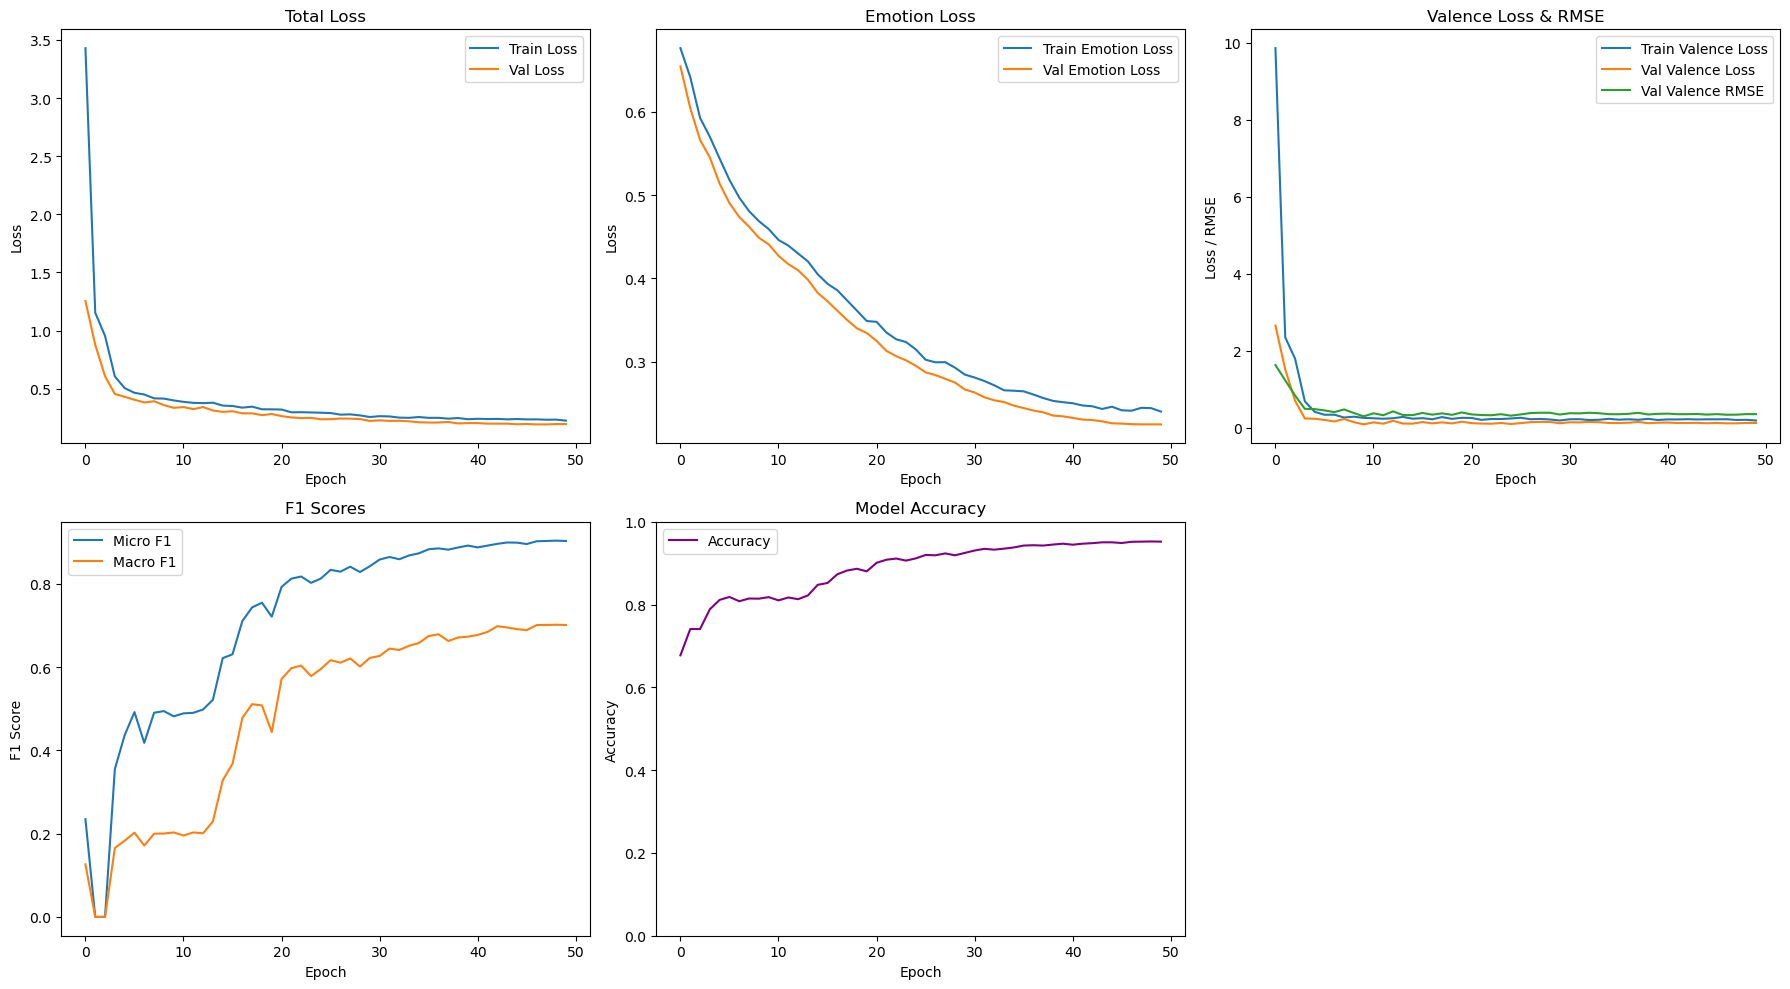

In [16]:

  # Plot the training history
def plot_training_history(history):
    # Create subplots - changed to 2x3 grid to add accuracy plot
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot total loss
    axs[0, 0].plot(history['train_total_loss'], label='Train Loss')
    axs[0, 0].plot(history['val_total_loss'], label='Val Loss')
    axs[0, 0].set_title('Total Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    # Plot emotion loss
    axs[0, 1].plot(history['train_emotion_loss'], label='Train Emotion Loss')
    axs[0, 1].plot(history['val_emotion_loss'], label='Val Emotion Loss')
    axs[0, 1].set_title('Emotion Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    
    # Plot valence loss and RMSE
    axs[0, 2].plot(history['train_valence_loss'], label='Train Valence Loss')
    axs[0, 2].plot(history['val_valence_loss'], label='Val Valence Loss')
    axs[0, 2].plot(history['val_valence_rmse'], label='Val Valence RMSE')
    axs[0, 2].set_title('Valence Loss & RMSE')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Loss / RMSE')
    axs[0, 2].legend()
    
    # Plot F1 scores
    axs[1, 0].plot(history['val_micro_f1'], label='Micro F1')
    axs[1, 0].plot(history['val_macro_f1'], label='Macro F1')
    axs[1, 0].set_title('F1 Scores')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].legend()
    
    # Plot accuracy
    axs[1, 1].plot(history['val_accuracy'], label='Accuracy', color='purple')
    axs[1, 1].set_title('Model Accuracy')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_ylim([0, 1])  # Accuracy is between 0 and 1
    axs[1, 1].legend()
    
    # Hide the unused subplot
    axs[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'dbert_training_history.png'))
    plt.show()

# Plot the training history
plot_training_history(history)

In [17]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader, emotion_criterion, valence_criterion, device):
    model.eval()
    test_emotion_loss = 0
    test_valence_loss = 0
    all_emotion_preds = []
    all_emotion_labels = []
    all_valence_preds = []
    all_valence_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotion_labels = batch['emotion_labels'].to(device)
            valence = batch['valence'].to(device)
            
            emotion_logits, valence_pred = model(input_ids, attention_mask)
            
            e_loss = emotion_criterion(emotion_logits, emotion_labels)
            v_loss = valence_criterion(valence_pred, valence)
            
            test_emotion_loss += e_loss.item()
            test_valence_loss += v_loss.item()
            
            # Convert logits to predictions
            emotion_preds = torch.sigmoid(emotion_logits).cpu().numpy() > 0.5 
            
            all_emotion_preds.extend(emotion_preds.astype(int).tolist())
            all_emotion_labels.extend(emotion_labels.cpu().numpy().astype(int).tolist())
            all_valence_preds.extend(valence_pred.cpu().numpy().flatten().tolist())
            all_valence_labels.extend(valence.cpu().numpy().flatten().tolist())
            
    # Calculate test metrics
    avg_test_emotion_loss = test_emotion_loss / len(test_loader)
    avg_test_valence_loss = test_valence_loss / len(test_loader)
    
    # F1 scores for emotion classification
    # Convert to numpy arrays
    emotion_preds_np = np.array(all_emotion_preds)
    emotion_labels_np = np.array(all_emotion_labels)
    
    # F1 scores for multi-label emotion classification
    micro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='micro', zero_division=0)
    macro_f1 = f1_score(emotion_labels_np, emotion_preds_np, average='macro', zero_division=0)
    
    # F1 scores for each class
    class_f1 = f1_score(all_emotion_labels, all_emotion_preds, average=None)
    class_report = {emotion: score for emotion, score in zip(all_emotions, class_f1)}
    
    # RMSE for valence prediction
    valence_rmse = np.sqrt(mean_squared_error(all_valence_labels, all_valence_preds))
    
    # Calculate accuracy for multi-label classification
    accuracy = np.mean(np.array(emotion_preds_np == emotion_labels_np, dtype=float))
    
    # Create a confusion matrix for multi-label is complex
    # Instead, analyze per-class precision, recall
    results = {
        'test_emotion_loss': avg_test_emotion_loss,
        'test_valence_loss': avg_test_valence_loss,
        'test_micro_f1': micro_f1,
        'test_macro_f1': macro_f1,
        'test_valence_rmse': valence_rmse,
        'test_accuracy': accuracy,  # Added accuracy
        'class_f1': class_report
    }
    
    # Print the results
    print(f"Test Results:")
    print(f"Emotion Loss: {avg_test_emotion_loss:.4f}")
    print(f"Valence Loss: {avg_test_valence_loss:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Valence RMSE: {valence_rmse:.4f}")
    print(f"Accuracy: {accuracy:.4f}")  # Added accuracy print statement
    
    # Save results
    with open(os.path.join(SAVE_DIR, 'dbert_test_results.json'), 'w') as f:
        json.dump(results, f)
    
    return results

In [18]:
# Load the best model for evaluation
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'dbert_best_model.pt')))

# Evaluate the model
test_results = evaluate_model(model, test_loader, emotion_criterion, valence_criterion, device)

print("\n")
# Print test results
'''A
print("\nTest Results:")
print(f"Emotion Loss: {test_results['test_emotion_loss']:.4f}")
print(f"Valence Loss: {test_results['test_valence_loss']:.4f}")
print(f"Micro F1: {test_results['test_micro_f1']:.4f}")
print(f"Macro F1: {test_results['test_macro_f1']:.4f}")
print(f"Valence RMSE: {test_results['test_valence_rmse']:.4f}")
print(f"Accuracy: {test_results['test_accuracy']:.4f}")
'''
print("\nClass-wise F1 Scores:")
for emotion, f1 in test_results['class_f1'].items():
    print(f"{emotion}: {f1:.4f}")

Testing:   0%|          | 0/23 [00:00<?, ?it/s]

Test Results:
Emotion Loss: 0.2291
Valence Loss: 0.1384
Micro F1: 0.8919
Macro F1: 0.6779
Valence RMSE: 0.3724
Accuracy: 0.9448



Class-wise F1 Scores:
Curiosity: 0.9520
Uncertainty: 0.9099
Excitement: 0.9528
Happiness: 0.9813
Surprise: 0.8358
Disgust: 0.7397
Fear: 0.0000
Frustration: 0.0513


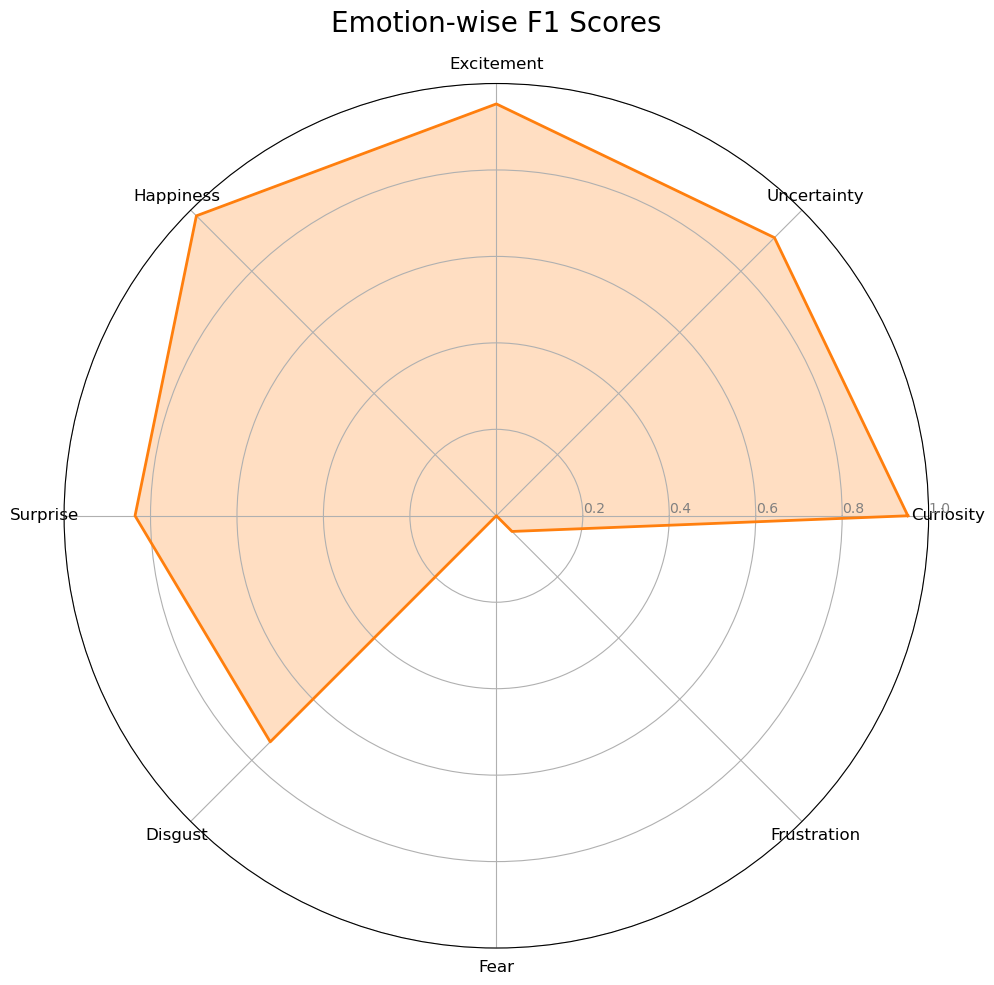

In [19]:
# Function to create and save radar chart
def create_emotion_radar_chart(class_f1, emotions, save_dir):
    # Number of variables
    N = len(emotions)
    
    # Get F1 scores in same order as emotions
    f1_scores = [class_f1[emotion] for emotion in emotions]
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # F1 scores for plotting (add first element at end to close the loop)
    values = f1_scores.copy()
    values += values[:1]  
    
    # Initialize the figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], emotions, fontsize=12)
    
    # Draw the y-axis labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], 
               fontsize=10, color="grey")
    plt.ylim(0, 1)
    
    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#FF7F0E')
    
    # Fill area
    ax.fill(angles, values, alpha=0.25, color='#FF7F0E')
    
    # Add title
    plt.title("Emotion-wise F1 Scores", size=20, y=1.05)
    
    # Add grid lines
    ax.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'dbert_emotion_F1s.png'))
    plt.show()
create_emotion_radar_chart(test_results["class_f1"], all_emotions, SAVE_DIR)

In [20]:
# Function to make predictions for a new input
def predict_emotions_and_valence(text, model, tokenizer, mlb, device):
    model.eval()
    
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        emotion_logits, valence_pred = model(input_ids, attention_mask)
        
        # Convert logits to predictions
        emotion_probs = torch.sigmoid(emotion_logits).cpu().numpy()
        emotion_preds = emotion_probs > 0.5
        
        # Get the predicted emotions
        predicted_emotions = mlb.inverse_transform(emotion_preds)[0]
        
        # Get the predicted valence
        predicted_valence = valence_pred.cpu().numpy().item()
        
        # Get the probabilities for each emotion
        emotion_probabilities = {emotion: prob for emotion, prob in zip(mlb.classes_, emotion_probs[0])}
    
    return predicted_emotions, predicted_valence, emotion_probabilities


In [21]:
# Example prediction function
test_text = "I am really excited about this new movie. The trailer looks amazing and I can't wait to see it!"
predicted_emotions, predicted_valence, emotion_probs = predict_emotions_and_valence(
    test_text, model, tokenizer, mlb, device
)

print("\nExample Prediction:")
print(f"Input text: {test_text}")
print(f"Predicted emotions: {predicted_emotions}")
print(f"Predicted valence: {predicted_valence:.2f}")
print("Emotion probabilities:")
for emotion, prob in emotion_probs.items():
    print(f"{emotion}: {prob:.4f}")


Example Prediction:
Input text: I am really excited about this new movie. The trailer looks amazing and I can't wait to see it!
Predicted emotions: ('Excitement', 'Happiness')
Predicted valence: 4.88
Emotion probabilities:
Curiosity: 0.1563
Uncertainty: 0.0921
Excitement: 0.5860
Happiness: 0.7354
Surprise: 0.1689
Disgust: 0.0824
Fear: 0.0758
Frustration: 0.1000


In [22]:

# Save the complete model, tokenizer, and configuration
model_save_path = os.path.join(SAVE_DIR, 'dbert')
os.makedirs(model_save_path, exist_ok=True)

# Save model configuration
model_config = {
    'model_name': 'distilbert-base-uncased',
    'n_emotions': len(all_emotions),
    'emotions': all_emotions,
    'valence_range': [df['Valence'].min(), df['Valence'].max()],
    'max_length': 512,
}

with open(os.path.join(model_save_path, 'config.json'), 'w') as f:
    json.dump(model_config, f)

# Save the model state
torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.pt'))

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"\nModel, tokenizer, and configuration saved to {model_save_path}")



Model, tokenizer, and configuration saved to /Users/rumenguin/Research/MERC/models/saved_model/dbert


In [23]:
# Final messages
print("\nTraining completed successfully!")
print(f"Best model saved to: {os.path.join(SAVE_DIR, 'dbert_best_model.pt')}")
print(f"Final model saved to: {os.path.join(SAVE_DIR, 'dbert_final_model.pt')}")
print(f"Complete model package saved to: {model_save_path}")
print(f"Training history plot saved to: {os.path.join(SAVE_DIR, 'dbert_training_history.png')}")
print(f"Training history saved to: {os.path.join(SAVE_DIR, 'dbert_training_history.json')}")
print(f"Test results saved to: {os.path.join(SAVE_DIR, 'dbert_test_results.json')}")


Training completed successfully!
Best model saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_best_model.pt
Final model saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_final_model.pt
Complete model package saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert
Training history plot saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_training_history.png
Training history saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_training_history.json
Test results saved to: /Users/rumenguin/Research/MERC/models/saved_model/dbert_test_results.json
